# Quantum-enhanced telescopy: Gottesman-Jennewein-Croke scheme

Implements the original GJC scheme to compute & reproduce the classical Fisher information of this. 
Here, a phase shift is encoded into a photon in the superposition of being collected by the left and right telescopes. 
An ancilla photon is distributed in a quantum network between the telescopes, and enables a quantum interference measurement between the two photon arriving the telescope modes.

<!-- ![10.1103/PhysRevLett.109.070503](assets/gjc_schematic.png) -->
<img src="assets/gjc_schematic.png" width=400 />
Source: 10.1103/PhysRevLett.109.070503

In [3]:
import itertools
from itertools import cycle

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.fock import BeamSplitter, FockState, Phase
from squint.utils import partition_op, print_nonzero_entries

In [4]:
cut = 4  # the photon number truncation for the simulation
circuit = Circuit()

# note: `wires` is a spatial mode in this context (in other contexts this can be a information carrying unit, e.g., a qubit/qudit)
# we add in the stellar photon, which is in an even superposition of spatial modes 0 and 2 (left and right telescopes)
circuit.add(
    FockState(
        wires=(
            0,
            2,
        ),
        n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
    )
)
# the stellar photon accumulates a phase shift prior to collection by the left telescope.
circuit.add(Phase(wires=(0,), phi=0.01), "phase")

# we add the resources photon, which is in an even superposition of spatial modes 1 and 3
circuit.add(
    FockState(
        wires=(
            1,
            3,
        ),
        n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
    )
)

# we add the linear optical circuit at each telescope (by default this is a 50-50 beamsplitter)
circuit.add(
    BeamSplitter(
        wires=(
            0,
            1,
        ),
    )
)
circuit.add(
    BeamSplitter(
        wires=(
            2,
            3,
        ),
    )
)
pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   FockState(
│     wires=(0, 2),
│     n=[(0.7071067811865476, (1, 0)), (0.7071067811865476, (0, 1))]
│   ),
│   'phase':
│   Phase(wires=(0,), phi=weak_f64[]),
│   2:
│   FockState(
│     wires=(1, 3),
│     n=[(0.7071067811865476, (1, 0)), (0.7071067811865476, (0, 1))]
│   ),
│   3:
│   BeamSplitter(wires=(0, 1), r=weak_f64[]),
│   4:
│   BeamSplitter(wires=(2, 3), r=weak_f64[])
  },
  _backend=None
)

In [5]:
# we split out the params which can be varied (in this example, it is just the "phase" phi value), and all the static parameters (wires, etc.)
params, static = partition_op(circuit, "phase")

# next we compile the circuit description into function calls, which compute, e.g., the quantum state, probabilities, partial derivates of the quantum state, and partial derivatives of the probabilities
sim = circuit.compile(params, static, dim=cut, optimize="greedy").jit()

# we define a function which indexes in the circuit object, and all other pytrees computed from it, a specific value. this will be necessary to access, e.g., the gradients
get = lambda pytree: jnp.array([pytree.ops["phase"].phi])

In [7]:
ket = sim.amplitudes.grad(params)
prob = sim.probabilities.forward(params)
grad = sim.probabilities.grad(params)

print_nonzero_entries(prob)

Basis: [0 0 0 2], Value: 0.12499997764825821
Basis: [0 0 2 0], Value: 0.12499997764825821
Basis: [0 1 0 1], Value: 0.2499936819076538
Basis: [0 1 1 0], Value: 6.249946181924315e-06
Basis: [0 2 0 0], Value: 0.12499997764825821
Basis: [1 0 0 1], Value: 6.249946181924315e-06
Basis: [1 0 1 0], Value: 0.2499936819076538
Basis: [2 0 0 0], Value: 0.12499997764825821


In [8]:
# we next compute the classical Fisher information
cfi = jnp.sum(get(grad) ** 2 / (prob + 1e-14))
print(f"The classical Fisher information for `phi` is {cfi}")

# this can also be performed from the `sim` object
cfim = sim.probabilities.cfim(get, params)
print(f"The classical Fisher information is {cfim}")

The classical Fisher information for `phi` is 0.49999993480057975
The classical Fisher information is [[0.49999993]]


In [9]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].phi, params, jnp.expand_dims(phis, axis=1)
)

probs = eqx.filter_vmap(sim.probabilities.forward)(params)

[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, 'Probability, $p(\\mathbf{x} | \\varphi)$')]

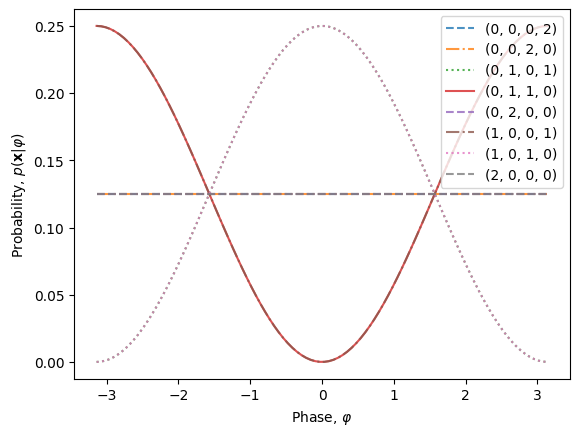

In [10]:
colors = cycle(sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:]))))
styles = cycle(["--", "-.", ":", "solid", "dashed", "dashdot", "dotted"])
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    if jnp.mean(probs[:, *idx]) < 1e-6:
        continue
    label = f"{idx}" if jnp.mean(probs[:, *idx]) > 1e-6 else None
    # print(label, jnp.mean(probs[:, *idx]))
    ax.plot(
        phis,
        probs[:, *idx],
        label=label,
        color=next(colors),
        ls=next(styles),
        alpha=0.8,
    )
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")